In [1]:
import evds as e
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
import statsmodels.api as sm
from scipy.stats import kruskal, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
with open("api_key.txt") as f:
    key = f.read()

In [3]:
evds = e.evdsAPI(key)

In [4]:
evds.get_series("bie_sgegi")

,SERIE_CODE,SERIE_NAME,START_DATE
0,TP.SGEGI.K1,A) Toplam Seyahat Geliri (Milyon ABD Doları) (...,01-01-2003
1,TP.SGEGI.K2,B) Marina Hizmet Harcamaları (Milyon ABD Doları),01-01-2003
2,TP.SGEGI.K3,C) Toplam Çıkış Yapan Ziyaretçi Sayısı (E+G),01-01-2003
3,TP.SGEGI.K4,Kişi Başına Ortalama Harcama (ABD Doları) (A/C),01-01-2003
4,TP.SGEGI.K5,D) Yabancı Ziyaretçi Seyahat Geliri (Milyon AB...,01-01-2003
5,TP.SGEGI.K6,E) Çıkış Yapan Yabancı Ziyaretçi Sayısı,01-01-2003
6,TP.SGEGI.K7,Kişi Başına Ortalama Harcama (ABD Doları) (D/E),01-01-2003
7,TP.SGEGI.K8,F) Yurt Dışı ikametli Vatandaş Seyahat Geliri ...,01-01-2003
8,TP.SGEGI.K9,G) Çıkış Yapan Yurt Dışı ikametli Vatandaş Sayısı,01-01-2003
9,TP.SGEGI.K10,Kişi Başına Ortalama Harcama (ABD Doları) (F/G),01-01-2003


In [5]:
data = evds.get_data(["TP.SGEGI.K1"], startdate = "01-01-2003", enddate = "09-12-2023")

In [6]:
data.head()

,Tarih,TP_SGEGI_K1
0,2003-1,379.0
1,2003-2,419.0
2,2003-3,408.0
3,2003-4,445.0
4,2003-5,779.0


In [7]:
data.rename(columns = {"Tarih": "date", "TP_SGEGI_K1": "tourism income"}, inplace = True)

In [8]:
data.columns

Index(['date', 'tourism income'], dtype='object')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            249 non-null    object 
 1   tourism income  247 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.0+ KB


In [10]:
data.date = pd.date_range("2003-1", periods = len(data), freq = "M")
data.set_index("date", inplace = True)

In [11]:
data.head()

,tourism income
date,
2003-01-31,379.0
2003-02-28,419.0
2003-03-31,408.0
2003-04-30,445.0
2003-05-31,779.0


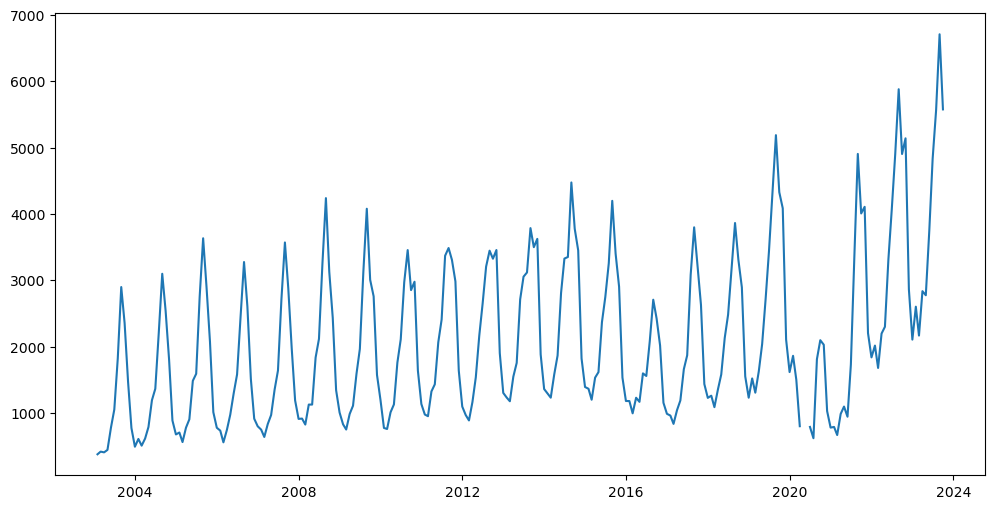

In [12]:
plt.figure(figsize = (12,6))
plt.plot(data);

In [13]:
data[data.isnull().any(axis = 1)]  

,tourism income
date,
2020-04-30,NaN
2020-05-31,NaN


In [14]:
# because of covid

In [15]:
data = data.interpolate()

In [16]:
data.loc[["2020-03-31", "2020-04-30", "2020-05-31", "2020-05-31", "2020-06-30"]]

,tourism income
date,
2020-03-31,802.000000
2020-04-30,798.333333
2020-05-31,794.666667
2020-05-31,794.666667
2020-06-30,791.000000


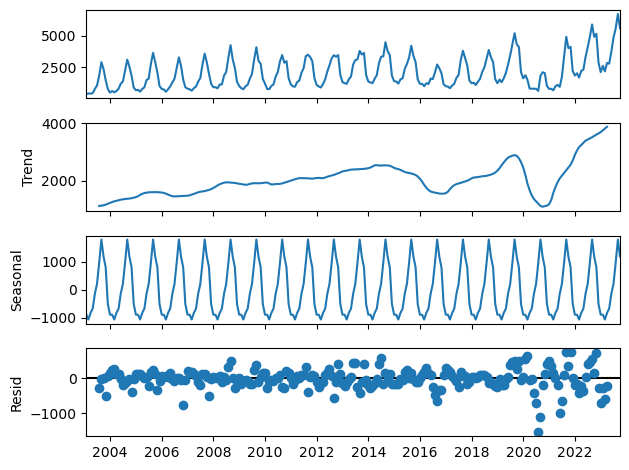

In [17]:
seasonal_decompose(data).plot();

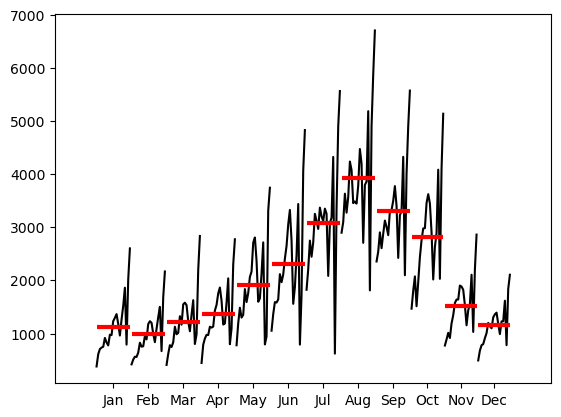

In [18]:
month_plot(data); # monthly avg

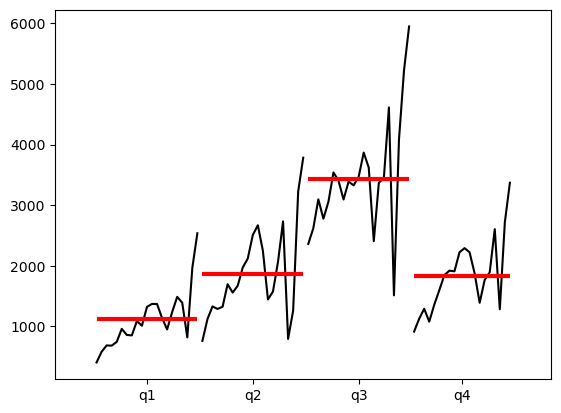

In [19]:
data_quarter = evds.get_data(["TP.SGEGI.K1"], startdate = "01-01-2003", enddate = "09-12-2023", frequency = 6)
data_quarter.rename(columns = {"Tarih": "date", "TP_SGEGI_K1": "tourism income"}, inplace = True)
data_quarter.date = pd.date_range("2003-01", periods = len(data_quarter), freq = "Q")
data_quarter.set_index("date", inplace = True)
data_quarter = data_quarter.interpolate()

quarter_plot(data_quarter);

In [20]:
# Seasonality Test with Dummy Vars

In [21]:
data_2 = data.copy()

In [22]:
# For quarter
data_2["quarter"] = data_2.index.quarter
data_2.head()

,tourism income,quarter
date,,
2003-01-31,379.0,1
2003-02-28,419.0,1
2003-03-31,408.0,1
2003-04-30,445.0,2
2003-05-31,779.0,2


In [23]:
data_2 = pd.get_dummies(data = data_2, columns = ["quarter"], prefix = "q", dtype = "int")
data_2.head()

,tourism income,q_1,q_2,q_3,q_4
date,,,,,
2003-01-31,379.0,1,0,0,0
2003-02-28,419.0,1,0,0,0
2003-03-31,408.0,1,0,0,0
2003-04-30,445.0,0,1,0,0
2003-05-31,779.0,0,1,0,0


In [24]:
X = data_2.drop(["tourism income"], axis = 1)
y = data_2["tourism income"]

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         tourism income   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     78.95
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           9.17e-36
Time:                        21:00:27   Log-Likelihood:                -2038.4
No. Observations:                 249   AIC:                             4085.
Df Residuals:                     245   BIC:                             4099.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
q_1         1114.6825    110.369     10.100      0.000     897.289    1332.076
q_2         1862.6508    110.369     16.877      0.000    1645.258    2080.044
q_3         3439.6032    110.369     31.165      0.000    3222.210    3656.996
q_4         1832.4833    113.095     16.203      0.000    1609.722    2055.245
==============================================================================
Omnibus:                       46.179   Durbin-Watson:                   0.820
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.097
Skew:                           0.999   Prob(JB):                     4.05e-18
Kurtosis:                       4.931   Cond. No.                         1.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
# q3 is the most highest

In [26]:
# For month
data_3 = data.copy()
data_3["month"] = data_3.index.month
data_3.head()

,tourism income,month
date,,
2003-01-31,379.0,1
2003-02-28,419.0,2
2003-03-31,408.0,3
2003-04-30,445.0,4
2003-05-31,779.0,5


In [27]:
data_3 = pd.get_dummies(data = data_3, columns = ["month"], prefix = "m", dtype = "int")
data_3.head()

,tourism income,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12
date,,,,,,,,,,,,,
2003-01-31,379.0,1,0,0,0,0,0,0,0,0,0,0,0
2003-02-28,419.0,0,1,0,0,0,0,0,0,0,0,0,0
2003-03-31,408.0,0,0,1,0,0,0,0,0,0,0,0,0
2003-04-30,445.0,0,0,0,1,0,0,0,0,0,0,0,0
2003-05-31,779.0,0,0,0,0,1,0,0,0,0,0,0,0


In [28]:
X = data_3.drop(["tourism income"], axis = 1)
y = data_3["tourism income"]

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         tourism income   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     35.56
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           3.75e-44
Time:                        21:00:27   Log-Likelihood:                -2001.2
No. Observations:                 249   AIC:                             4026.
Df Residuals:                     237   BIC:                             4069.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
m_1         1130.8571    167.420      6.755      0.000     801.036    1460.678
m_2          987.1429    167.420      5.896      0.000     657.322    1316.964
m_3         1226.0476    167.420      7.323      0.000     896.226    1555.869
m_4         1362.8254    167.420      8.140      0.000    1033.004    1692.647
m_5         1920.6508    167.420     11.472      0.000    1590.829    2250.472
m_6         2304.4762    167.420     13.765      0.000    1974.655    2634.297
m_7         3081.6190    167.420     18.407      0.000    2751.798    3411.440
m_8         3929.0952    167.420     23.469      0.000    3599.274    4258.917
m_9         3308.0952    167.420     19.759      0.000    2978.274    3637.917
m_10        2816.7000    171.554     16.419      0.000    2478.734    3154.666
m_11        1523.8000    171.554      8.882      0.000    1185.834    1861.766
m_12        1156.9500    171.554      6.744      0.000     818.984    1494.916
==============================================================================
Omnibus:                       36.946   Durbin-Watson:                   0.156
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.323
Skew:                           0.792   Prob(JB):                     2.40e-15
Kurtosis:                       4.995   Cond. No.                         1.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
# with ANOVA
# H0: No difference between the group avgs
# H1: There is a difference

data_anova = data.copy()
data_anova["month"] = data_3.index.month
data_anova.head()

f_one_way = f_oneway(data_anova["tourism income"], data_anova["month"])  # parametric
kw = kruskal(data_anova["tourism income"], data_anova["month"])          # non-parametric

print(f_one_way)
print(kw)

F_onewayResult(statistic=707.7556739510354, pvalue=1.4950112119418872e-97)
KruskalResult(statistic=373.0752393699486, pvalue=4.0052216740820104e-83)


In [30]:
# pvalue < 0.5 -> H0 reject

In [31]:
# which group avgs are different?

# with groupby()
print(data_anova.groupby("month").mean().sort_values(by = "tourism income", ascending = False))

print("\n----------------------------------------------------------\n")

# with tukey test
tukey = pairwise_tukeyhsd(data_anova["tourism income"], data_anova["month"])
print(tukey)

       tourism income
month                
8         3929.095238
9         3308.095238
7         3081.619048
10        2816.700000
6         2304.476190
5         1920.650794
11        1523.800000
4         1362.825397
3         1226.047619
12        1156.950000
1         1130.857143
2          987.142857

----------------------------------------------------------

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj    lower      upper    reject
------------------------------------------------------------
     1      2  -143.7143    1.0  -925.3054   637.8768  False
     1      3    95.1905    1.0  -686.4007   876.7816  False
     1      4   231.9683  0.998  -549.6229  1013.5594  False
     1      5   789.7937 0.0451     8.2025  1571.3848   True
     1      6   1173.619 0.0001   392.0279  1955.2102   True
     1      7  1950.7619    0.0  1169.1708   2732.353   True
     1      8  2798.2381    0.0   2016.647  3579.8292   True
     1      9  2177.2

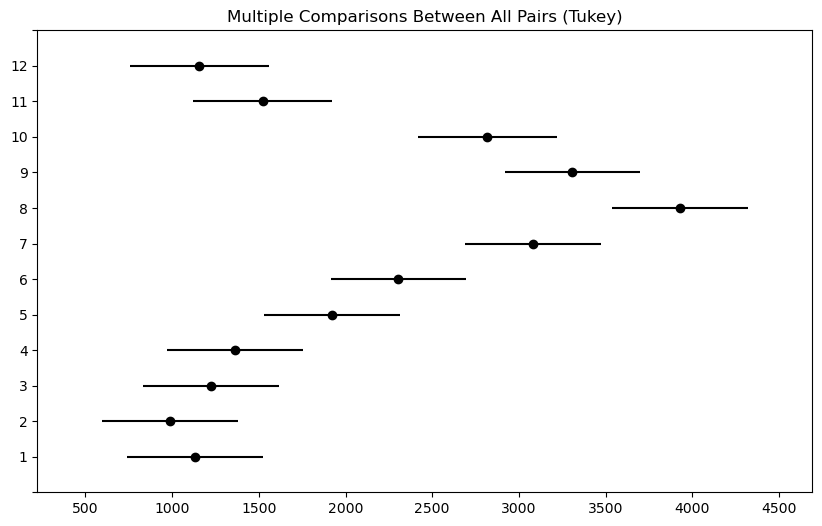

In [32]:
tukey.plot_simultaneous();